# 1. Install Dependencies and Setup

In [3]:
!pip install tensorflow opencv-python matplotlib

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.8.0-cp311-cp311-win_amd64.whl (2.6 MB)
  Using cached jax-0.4.10-py3-none-any.whl
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.23.2-cp310-abi3-win_amd64.whl (422 kB)
  Using cached grpcio-1.54.2-cp311-cp311-win_amd64.whl (4.1 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  U


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
!pip list

Package                      Version
---------------------------- --------
absl-py                      1.4.0
astunparse                   1.6.3
cachetools                   5.3.0
certifi                      2023.5.7
charset-normalizer           3.1.0
cmake                        3.26.3
contourpy                    1.0.7
cycler                       0.11.0
flatbuffers                  23.5.9
fonttools                    4.39.4
gast                         0.4.0
google-auth                  2.18.1
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.54.2
h5py                         3.8.0
idna                         3.4
jax                          0.4.10
keras                        2.12.0
kiwisolver                   1.4.4
libclang                     16.0.0
Markdown                     3.4.3
MarkupSafe                   2.1.2
matplotlib                   3.7.1
ml-dtypes                    0.1.0
numpy                        1.23.5
oaut

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('CPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

C:\Users\iRube\AppData\Local\Temp\ipykernel_2732\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'data' #path for data 

In [7]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png'] #list of valid img extensions

In [8]:
for image_class in os.listdir(data_dir): #looping in data for flood or wildfires
    for image in os.listdir(os.path.join(data_dir, image_class)): #looping thru each img in flood or wildfires
        image_path = os.path.join(data_dir, image_class, image)#gets the img in image_path
        try: 
            img = cv2.imread(image_path) #cv2 will save the image in numPy array format
            tip = imghdr.what(image_path)
            if tip not in image_exts:  # check if the img has an extension in 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
#builds image data set while compiling, automatically reshapes images for consistancy and also batches them up to sie 32
data = tf.keras.utils.image_dataset_from_directory('data')


Found 311 files belonging to 3 classes.


In [11]:
data_iterator = data.as_numpy_iterator() #access the data from the image data set or datapipeline

In [12]:
batch = data_iterator.next() #get another batch frim itr

In [13]:
# batch[0].shape, represents each image as numpy arrays
#class 0 = Floods
#class 1 = tornadoes
#class 2 = wildfire

#batch[1] = labels

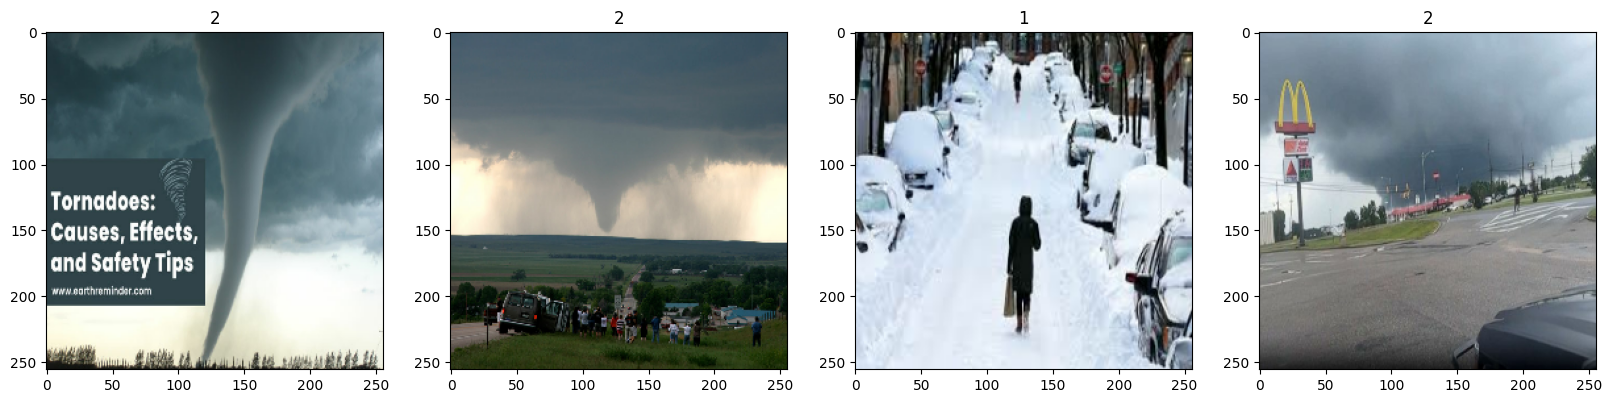

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #using matplotlib to show 4 images 
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y)) #data.map allows for transforming data in data pipeline itself so its faster to load data from a smaller size.
# using lambda for transformation, x is being transformed as its an img in numpy array, y is a label so no transforming that

In [16]:
scaled = data.as_numpy_iterator()

In [17]:
batch = scaled.next()

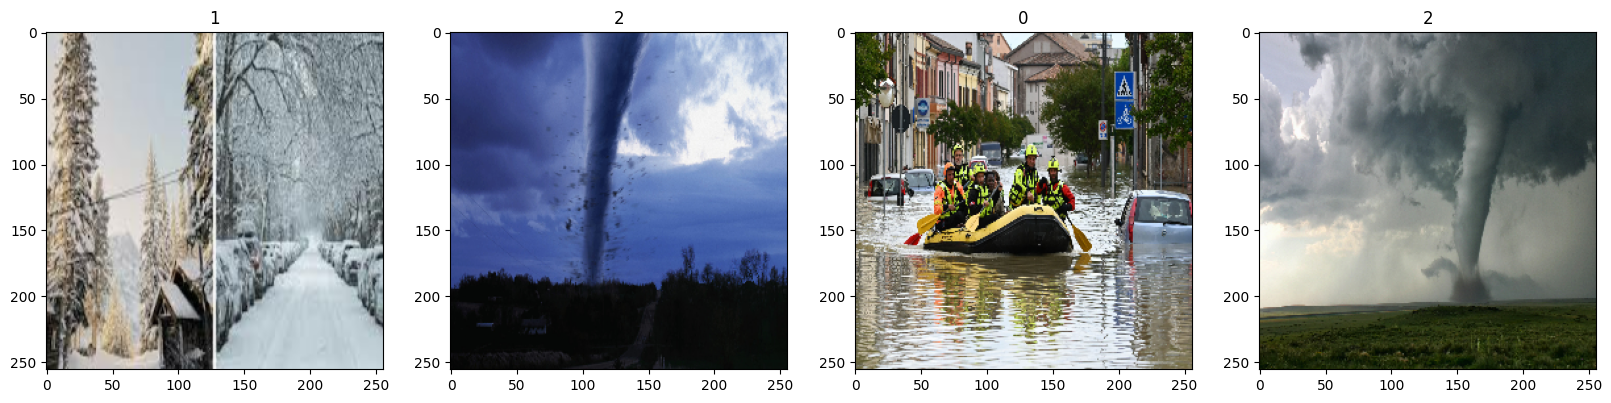

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) #using matplotlib to show 4 images 
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img) #cus dataset is between 0 - 1
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [19]:
#splitting dataset bacthes for training dataset, validation dataset, testing dataset
len(data)
train_size = int(len(data)*.7)#70% training data size 
val_size = int(len(data)*.2)  #20% to validation
test_size = int(len(data)*.1) #10% to testing




In [20]:
train = data.take(train_size) #take 4 batches 
val = data.skip(train_size).take(val_size) #skip first 4 batches then take the next 2
test = data.skip(train_size+val_size).take(test_size) # skip 6


In [21]:
# Convert labels to one-hot encoded format
train = train.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
val = val.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
test = test.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

# 6. Build Deep Learning Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [23]:
model = Sequential()

In [24]:
#adding layers sequencially

#The number of filters in the convolutional layers is 32, 64, and 128 respectively. 
#This allows the model to capture more features at different levels of abstraction.

model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3))) 
model.add(MaxPooling2D()) #condense image 

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

#L2 regularization with a weight decay of 0.001 has been added to the fully connected layers.
#This helps prevent overfitting by adding a penalty term to the loss function.

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
#Dropout layers with a rate of 0.5 have been added after each fully connected layer. Dropout randomly drops out a fraction
#of the connections during training which can improve generalization and reduce overfitting.

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))# output will give probabilities for each class, used sigmoid for 0 or 1 for two classes

In [25]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy']) #used binry accuracies 
#adam is an optimizer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

# 7. Training DL Model

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
7/7 [==============================] - 16s 2s/step - loss: 4.1360 - accuracy: 0.2946 - val_loss: 1.6167 - val_accuracy: 0.4375
Epoch 2/20
7/7 [==============================] - 14s 2s/step - loss: 1.6416 - accuracy: 0.4152 - val_loss: 1.5875 - val_accuracy: 0.4844
Epoch 3/20
7/7 [==============================] - 14s 2s/step - loss: 1.5894 - accuracy: 0.5670 - val_loss: 1.4740 - val_accuracy: 0.7344
Epoch 4/20
7/7 [==============================] - 14s 2s/step - loss: 1.4538 - accuracy: 0.6473 - val_loss: 1.3730 - val_accuracy: 0.6719
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 1.3625 - accuracy: 0.7009 - val_loss: 1.2458 - val_accuracy: 0.6719
Epoch 6/20
7/7 [==============================] - 14s 2s/step - loss: 1.1810 - accuracy: 0.7545 - val_loss: 1.0162 - val_accuracy: 0.8438
Epoch 7/20
7/7 [==============================] - 14s 2s/step - loss: 1.2292 - accuracy: 0.7500 - val_loss: 0.9563 - val_accuracy: 0.8281
Epoch 8/20
7/7 [==================

# 8. Ploting Performance

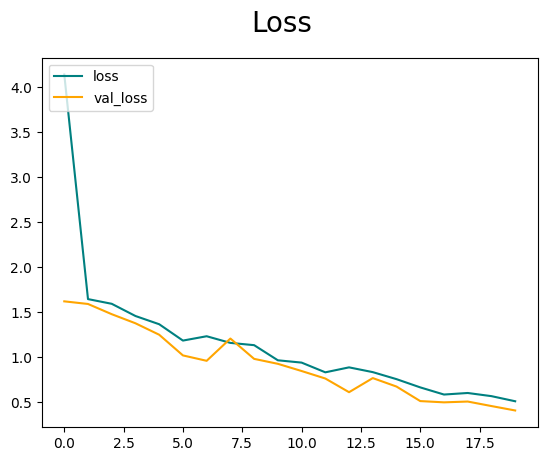

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

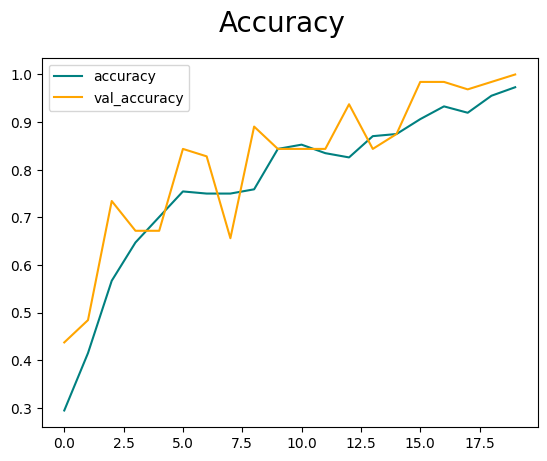

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [33]:
len(test)

1

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 0s 335ms/step


In [49]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1.0 1.0 1.0


# 10. Test

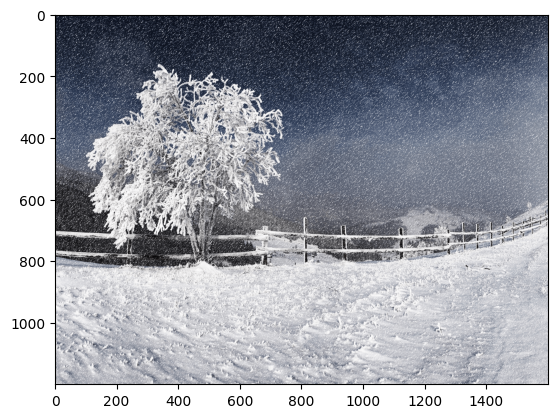

In [51]:
#cv2 will display img in BGR
img = cv2.imread('snowstormtest.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))#converting img to show in rgb
plt.show()

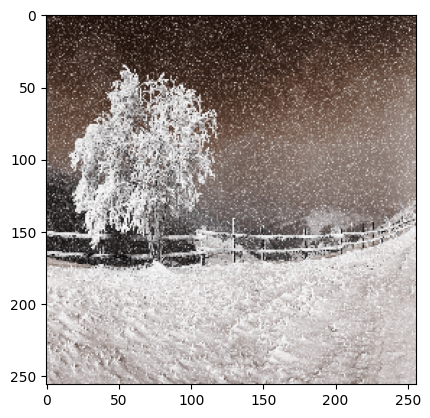

In [52]:
resize = tf.image.resize(img, (256,256)) #need to resize
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
#expanding the img to the batch and resizing it and then adding it to the predict method
finalAccuracy = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 48ms/step


In [62]:
finalAccuracy

array([[0.234221  , 0.76396495, 0.00181408]], dtype=float32)

In [63]:
class_names = ['Floods', 'Snowstorm', 'Tornado']

predicted_class_index = np.argmax(finalAccuracy)
predicted_class = class_names[predicted_class_index]

print(f'Predicted class is {predicted_class}')

Predicted class is Snowstorm


# 11. Save the Model

In [56]:
from tensorflow.keras.models import load_model

In [57]:
model.save(os.path.join('models','Classify_tornado_flood_snowstorm.h5'))

In [58]:
new_model = load_model(os.path.join('models','Classify_tornado_flood_snowstorm.h5'))

In [59]:
yhatNew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 116ms/step


In [60]:
predicted_class_index_new = np.argmax(yhatNew)
predicted_class_new = class_names[predicted_class_index_new]

print(f'Predicted class is {predicted_class_new}')

Predicted class is Snowstorm
